Cross-Validation on Training Set (k=5):
Accuracy: 88.45%
Sensitivity (Recall): 91.27%
Specificity: 84.68%
Precision: 88.83%
F1-Score: 90.03%
Negative Predictive Value: 87.89%
False Positive Rate: 15.32%
False Discovery Rate: 11.17%
False Negative Rate: 8.73%

--------------------------------------------------

Final Evaluation:
Accuracy: 87.01%
Sensitivity (Recall): 92.66%
Specificity: 79.45%
Precision: 85.77%
F1-Score: 89.08%
Negative Predictive Value: 89.00%
False Positive Rate: 20.55%
False Discovery Rate: 14.23%
False Negative Rate: 7.34%

Script Execution Time: 0.3834 seconds



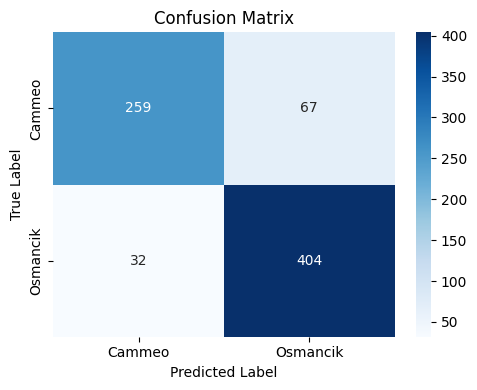

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Start measuring time
start = time.time()

# Load the dataset
data = pd.read_excel("../data/rice.xlsx")

# Drop the 'Number' column if it exists
if 'Number' in data.columns:
    data = data.drop('Number', axis=1)

# Separate features and labels
X = data.drop('Type', axis=1).values
y = data['Type'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)
class_labels = le.classes_

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train (80%) and test (20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize K-Fold
k_value = 5
kf = KFold(n_splits=k_value, shuffle=True, random_state=42)

# Function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    ACC = (tp + tn) / (tp + tn + fp + fn) * 100
    TPR = tp / (tp + fn) * 100 if (tp + fn) != 0 else 0
    SPC = tn / (tn + fp) * 100 if (tn + fp) != 0 else 0
    PPV = tp / (tp + fp) * 100 if (tp + fp) != 0 else 0
    F1 = (2 * tp) / (2 * tp + fp + fn) * 100 if (2 * tp + fp + fn) != 0 else 0
    NPV = tn / (tn + fn) * 100 if (tn + fn) != 0 else 0
    FPR = fp / (fp + tn) * 100 if (fp + tn) != 0 else 0
    FDR = fp / (fp + tp) * 100 if (fp + tp) != 0 else 0
    FNR = fn / (fn + tp) * 100 if (fn + tp) != 0 else 0

    return {
        'Accuracy': ACC,
        'Sensitivity (Recall)': TPR,
        'Specificity': SPC,
        'Precision': PPV,
        'F1-Score': F1,
        'Negative Predictive Value': NPV,
        'False Positive Rate': FPR,
        'False Discovery Rate': FDR,
        'False Negative Rate': FNR
    }

# Function to evaluate on training folds (no test data leakage)
def run_kfold_training_evaluation(kf, X_trainval, y_trainval):
    metrics_list = []

    for train_idx, val_idx in kf.split(X_trainval):
        X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
        y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]

        model = GaussianNB()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        metrics = calculate_metrics(y_val, y_pred)
        metrics_list.append(metrics)

    avg_metrics = {key: np.mean([m[key] for m in metrics_list]) for key in metrics_list[0]}
    return avg_metrics

# Train using k-folds on training set only
print("Cross-Validation on Training Set (k=5):")
training_metrics = run_kfold_training_evaluation(kf, X_trainval, y_trainval)
for metric, value in training_metrics.items():
    print(f"{metric}: {value:.2f}%")

print("\n" + "-"*50 + "\n")

# Train on full training set and test once on holdout test set
final_model = GaussianNB()
final_model.fit(X_trainval, y_trainval)
y_test_pred = final_model.predict(X_test)

test_metrics = calculate_metrics(y_test, y_test_pred)

print("Final Evaluation:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.2f}%")

# Stop timing
end = time.time()
print(f"\nScript Execution Time: {end - start:.4f} seconds\n")

# Plot confusion matrix for test set
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_test, y_test_pred, "Confusion Matrix")
